In [3]:
# !ls /home/jupyter/.fastai/data/oxford-iiit-pet/crappy

In [1]:
import matplotlib.pyplot as plt
import cv2
from keras.models import Model
from keras.layers import Input, BatchNormalization, Dropout, Activation, Add, ZeroPadding2D, UpSampling2D, Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
def showImage(imgs):
    num = len(imgs)
    f = plt.figure()
    for i in range(num):
        
        f.add_subplot(1, num, i+1)
        plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
    plt.show(block=True)

(334, 500, 3)
(96, 143, 3)


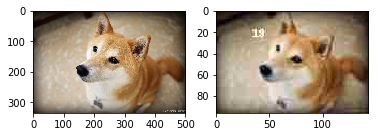

In [3]:
# test_p = './data/pets/shiba_inu/shiba_inu_27.jpg'
test_p = '/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_11.jpg'
img = cv2.imread(test_p)
print(img.shape)
test_imgs = []
test_imgs.append(img)

test_p = '/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/shiba_inu_11.jpg'
img2 = cv2.imread(test_p)
print(img2.shape)
test_imgs.append(img2)
showImage(test_imgs)

In [4]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation:
        x = BatchActivate(x)
    return x
def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [20]:
def build_model(inputLayer, start_neurons, dropout_rate=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    print(conv1.shape)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    print(conv1.shape)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_rate/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    print(conv2.shape)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    print(conv2.shape)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    print(conv3.shape)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    print(conv3.shape)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    print(conv4.shape)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    print(conv4.shape)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    print(convm.shape)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    print('deconv4', deconv4.shape)
    print('conv4', conv4.shape)
    uconv4 = concatenate([deconv4, conv4])
    print('uconv4', uconv4.shape)
    uconv4 = Dropout(dropout_rate)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    print('deconv3', deconv3.shape)
    print('conv3', conv3.shape)
    uconv3 = concatenate([deconv3, conv3])    
    print('uconv3', uconv3.shape)
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(dropout_rate)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(dropout_rate)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [21]:
img_size_target=224
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=['acc'])

#model1.summary()

(?, 224, 224, 16)
(?, 224, 224, 16)
(?, 112, 112, 32)
(?, 112, 112, 32)
(?, 56, 56, 64)
(?, 56, 56, 64)
(?, 28, 28, 128)
(?, 28, 28, 128)
(?, 14, 14, 256)
deconv4 (?, ?, ?, 128)
conv4 (?, 28, 28, 128)
uconv4 (?, 28, 28, 256)
deconv3 (?, ?, ?, 64)
conv3 (?, 56, 56, 64)
uconv3 (?, 56, 56, 128)


In [4]:
# model1.summary()

In [5]:
# from keras.applications import ResNet50
# test = ResNet50()
# test.summary()

## FROM HERE

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor]) 
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)
    return x

In [5]:
def create_resnet(input_shape=None):

    inputs = Input(shape=input_shape)
    
    ## --- CONV1 ----
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs) #  230x230x3
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)  #  112x112x64
    bn_conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1) #  112x112x64
    bn_conv1 = Activation('relu')(bn_conv1) #  112x112x64
    pool1_pad = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(bn_conv1)  # 114x114x64
    pool1_pad = MaxPooling2D((3, 3), strides=(2, 2))(pool1_pad)  # 56x56x64
    
    ## --- CONV2 ---     56x56x256
    conv2a = conv_block(pool1_pad, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1)) 
    conv2b = identity_block(conv2a, 3, [64, 64, 256], stage=2, block='b')
    conv2c = identity_block(conv2b, 3, [64, 64, 256], stage=2, block='c')

    ## --- CONV3---     28x28x512
    conv3a = conv_block(conv2c, 3, [128, 128, 512], stage=3, block='a') #
    conv3b = identity_block(conv3a, 3, [128, 128, 512], stage=3, block='b')
    conv3c = identity_block(conv3b, 3, [128, 128, 512], stage=3, block='c')
    conv3d = identity_block(conv3c, 3, [128, 128, 512], stage=3, block='d')

    ## --- CONV4 ---     14x14x1024
    conv4a = conv_block(conv3d, 3, [256, 256, 1024], stage=4, block='a')
    conv4b = identity_block(conv4a, 3, [256, 256, 1024], stage=4, block='b')
    conv4c = identity_block(conv4b, 3, [256, 256, 1024], stage=4, block='c')
    conv4d = identity_block(conv4c, 3, [256, 256, 1024], stage=4, block='d')
    conv4e = identity_block(conv4d, 3, [256, 256, 1024], stage=4, block='e')
    conv4f = identity_block(conv4e, 3, [256, 256, 1024], stage=4, block='f')

    ## --- CONV5 ---     7x7x2048
    conv5a = conv_block(conv4f, 3, [512, 512, 2048], stage=5, block='a')
    conv5b = identity_block(conv5a, 3, [512, 512, 2048], stage=5, block='b')
#     conv5c = identity_block(conv5b, 3, [512, 512, 2048], stage=5, block='c')
    outputs = identity_block(conv5b, 3, [512, 512, 2048], stage=5, block='c')
    
    model = Model(inputs, outputs, name='resnet50-unet')
    
    return model

In [6]:
def create_resUnet_normal_upsampling(input_shape=None):

    inputs = Input(shape=input_shape)
    
    ## --- BLOCK 1 ----  OUT   56x56x64
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs) #  230x230x3
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)  #  112x112x64
    bn_conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1) #  112x112x64
    bn_conv1 = Activation('relu')(bn_conv1) #  112x112x64
    pool1_pad = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(bn_conv1)  # 114x114x64
    pool1_pad = MaxPooling2D((3, 3), strides=(2, 2))(pool1_pad)  # 56x56x64
    
    ## --- BLOCK 2 ---    OUT   56x56x256
    conv2a = conv_block(pool1_pad, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1)) 
    conv2b = identity_block(conv2a, 3, [64, 64, 256], stage=2, block='b')
    conv2c = identity_block(conv2b, 3, [64, 64, 256], stage=2, block='c')

    ## --- BLOCK 3---     OUT   28x28x512
    conv3a = conv_block(conv2c, 3, [128, 128, 512], stage=3, block='a') #
    conv3b = identity_block(conv3a, 3, [128, 128, 512], stage=3, block='b')
    conv3c = identity_block(conv3b, 3, [128, 128, 512], stage=3, block='c')
    conv3d = identity_block(conv3c, 3, [128, 128, 512], stage=3, block='d')

    ## --- BLOCK 4 ---     OUT   14x14x1024
    conv4a = conv_block(conv3d, 3, [256, 256, 1024], stage=4, block='a')
    conv4b = identity_block(conv4a, 3, [256, 256, 1024], stage=4, block='b')
    conv4c = identity_block(conv4b, 3, [256, 256, 1024], stage=4, block='c')
    conv4d = identity_block(conv4c, 3, [256, 256, 1024], stage=4, block='d')
    conv4e = identity_block(conv4d, 3, [256, 256, 1024], stage=4, block='e')
    conv4f = identity_block(conv4e, 3, [256, 256, 1024], stage=4, block='f')

    ## --- BLOCK 5 ---     OUT     7x7x2048
    conv5a = conv_block(conv4f, 3, [512, 512, 2048], stage=5, block='a')
    conv5b = identity_block(conv5a, 3, [512, 512, 2048], stage=5, block='b')
    conv5c = identity_block(conv5b, 3, [512, 512, 2048], stage=5, block='c')
    drop5 = Dropout(0.3)(conv5c)
    
    ## --- BLOCK6 ---     OUT     14x14x1024
    up6 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop5)) # 14x14x512
    merge6 = Concatenate(axis=3)([conv4f, up6]) # 14x14x1576
    conv6 = Conv2D(1024, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization(axis=3, name='block6_a')(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(1024, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(axis=3, name='block6_b')(conv6)
    conv6 = Activation('relu')(conv6)
    drop6 = Dropout(0.3)(conv6)
    
    ## --- BLOCK7 ---     OUT     28x28x512
    up7 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop6)) # 14x14x256
    merge7 = Concatenate(axis=3)([conv3d, up7]) # 14x14x768
    conv7 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization(axis=3, name='block7_a')(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(axis=3, name='block7_b')(conv7)
    conv7 = Activation('relu')(conv7)
    drop7 = Dropout(0.3)(conv7)
    
    ## --- BLOCK8---     OUT     56x56x256
    up8 = Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop7)) #  56x56x128
    merge8 = Concatenate(axis=3)([conv2c, up8]) # 56x56x378
    conv8 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization(axis=3, name='block8_a')(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization(axis=3, name='block8_b')(conv8)
    conv8 = Activation('relu')(conv8)
    drop8 = Dropout(0.3)(conv8)
    
    
    ## --- BLOCK9---     OUT     112x112x64
    up9 = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop8)) #  112x112x32
    merge9 = Concatenate(axis=3)([bn_conv1, up9]) # 112x112x96
    conv9 = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization(axis=3, name='block9_a')(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis=3, name='block9_b')(conv9)
    conv9 = Activation('relu')(conv9)
    drop9 = Dropout(0.3)(conv9)  # 112x112x 64
    
    ## --- BLOCK10---     OUT     224x224x3
    up10 = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop9)) #  224x224x32
    conv10 = BatchNormalization(axis=3, name='block10_a')(up10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(3, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv10)
    outputs = BatchNormalization(axis=3, name='block10_b')(conv10)
#     outputs = Activation('relu')(conv10)
    
    model = Model(inputs, outputs, name='resnet50-unet_normal_upsampling')
    
    return model

In [7]:
def create_resUnet_residual_upsampling(input_shape=None):

    inputs = Input(shape=input_shape)
    
    ## --- BLOCK 1 ----  OUT   56x56x64
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs) #  230x230x3
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', name='conv1')(x)  #  112x112x64
    bn_conv1 = BatchNormalization(axis=3, name='bn_conv1')(conv1) #  112x112x64
    bn_conv1 = Activation('relu')(bn_conv1) #  112x112x64
    pool1_pad = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(bn_conv1)  # 114x114x64
    pool1_pad = MaxPooling2D((3, 3), strides=(2, 2))(pool1_pad)  # 56x56x64
    
    ## --- BLOCK 2 ---    OUT   56x56x256
    conv2a = conv_block(pool1_pad, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1)) 
    conv2b = identity_block(conv2a, 3, [64, 64, 256], stage=2, block='b')
    conv2c = identity_block(conv2b, 3, [64, 64, 256], stage=2, block='c')

    ## --- BLOCK 3---     OUT   28x28x512
    conv3a = conv_block(conv2c, 3, [128, 128, 512], stage=3, block='a') #
    conv3b = identity_block(conv3a, 3, [128, 128, 512], stage=3, block='b')
    conv3c = identity_block(conv3b, 3, [128, 128, 512], stage=3, block='c')
    conv3d = identity_block(conv3c, 3, [128, 128, 512], stage=3, block='d')

    ## --- BLOCK 4 ---     OUT   14x14x1024
    conv4a = conv_block(conv3d, 3, [256, 256, 1024], stage=4, block='a')
    conv4b = identity_block(conv4a, 3, [256, 256, 1024], stage=4, block='b')
    conv4c = identity_block(conv4b, 3, [256, 256, 1024], stage=4, block='c')
    conv4d = identity_block(conv4c, 3, [256, 256, 1024], stage=4, block='d')
    conv4e = identity_block(conv4d, 3, [256, 256, 1024], stage=4, block='e')
    conv4f = identity_block(conv4e, 3, [256, 256, 1024], stage=4, block='f')

    ## --- BLOCK 5 ---     OUT     7x7x2048
    conv5a = conv_block(conv4f, 3, [512, 512, 2048], stage=5, block='a')
    conv5b = identity_block(conv5a, 3, [512, 512, 2048], stage=5, block='b')
    conv5c = identity_block(conv5b, 3, [512, 512, 2048], stage=5, block='c')
    drop5 = Dropout(0.3)(conv5c)
    
    ## --- BLOCK6 ---     OUT     14x14x1024
    up6 = Conv2D(1024, kernel_size=3, padding='same', kernel_initializer='he_normal', name='up6')(UpSampling2D()(drop5)) # 14x14x1024
    merge6 = Concatenate(axis=3)([conv4f, up6]) # 14x14x2048
    conv6a = conv_block(merge6, 3, [512, 512, 1024], stage=6, block='a', strides=(1, 1))
    conv6b = identity_block(conv6a, 3, [512, 512, 1024], stage=6, block='b')
    conv6c = identity_block(conv6b, 3, [512, 512, 1024], stage=6, block='c')
    conv6d = identity_block(conv6b, 3, [512, 512, 1024], stage=6, block='d')
    conv6e = identity_block(conv6c, 3, [512, 512, 1024], stage=6, block='e')
    conv6f = identity_block(conv6e, 3, [512, 512, 1024], stage=6, block='f')
    drop6 = Dropout(0.3)(conv6f)
    
    ## --- BLOCK7 ---     OUT     28x28x512
    up7 = Conv2D(512, kernel_size=3, padding='same', kernel_initializer='he_normal', name='up7')(UpSampling2D()(drop6)) # 28x28x512
    merge7 = Concatenate(axis=3)([conv3d, up7]) # 28x28x1024
    conv7a = conv_block(merge7, 3, [256, 256, 512], stage=7, block='a', strides=(1, 1)) #
    conv7b = identity_block(conv7a, 3, [256, 256, 512], stage=7, block='b')
    conv7c = identity_block(conv7b, 3, [256, 256, 512], stage=7, block='c')
    conv7d = identity_block(conv7c, 3, [256, 256, 512], stage=7, block='d')
    drop7 = Dropout(0.3)(conv7d)
    
    ## --- BLOCK8---     OUT     56x56x256
    up8 = Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal', name='up8')(UpSampling2D()(drop7)) #  56x56x256
    merge8 = Concatenate(axis=3)([conv2c, up8]) # 56x56x512
    conv8a = conv_block(merge8, 3, [128, 128, 256], stage=8, block='a', strides=(1, 1)) 
    conv8b = identity_block(conv8a, 3, [128, 128, 256], stage=8, block='b')
    conv8c = identity_block(conv8b, 3, [128, 128, 256], stage=8, block='c')
    drop8 = Dropout(0.3)(conv8c)
    
    ## --- BLOCK9---     OUT     112x112x64
    up9 = Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal', name='up9')(UpSampling2D()(drop8)) #  112x112x64
    merge9 = Concatenate(axis=3)([bn_conv1, up9]) # 112x112x128
    conv9a = conv_block(merge8, 3, [32, 32, 64], stage=9, block='a', strides=(1, 1)) 
    drop9 = Dropout(0.3)(conv9a)  # 112x112x 64
    
    ## --- BLOCK10---     OUT     224x224x3
    up10 = Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(UpSampling2D()(drop9)) #  224x224x32
    conv10 = BatchNormalization(axis=3, name='block10_a')(up10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(3, kernel_size=3, padding='same', kernel_initializer='he_normal')(conv10)
    conv10 = BatchNormalization(axis=3, name='block10_b')(conv10)
    outputs = Activation('relu')(conv10)
    
    model = Model(inputs, outputs, name='resnet50-unet_normal_upsampling')
    
    return model

In [8]:
def adjust_image(img, mask):
    img = img / 255.
    mask = mask[:,:,0] if len(mask.shape) == 3 else mask[:,:,:,0]
    new_mask = np.zeros(mask.shape + (len(codes),))
    for i in range(len(codes)):
        new_mask[mask == i, i] = 1
    mask = new_mask
    return (img,mask)

In [8]:
from keras.applications.resnet50 import preprocess_input
import numpy as np
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

def normalization(img, rgb_mean=DIV2K_RGB_MEAN):
#     return (img - rgb_mean) / 127.5
    return (img - 127.5) / 127.5

def denormalization(img, rgb_mean=DIV2K_RGB_MEAN):
#     return img * 127.5 + rgb_mean
    return img * 127.5 + 127.5

In [9]:
def data_generator(path, input_path, output_path, size, batch_size=4, seed=1):
    data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

    input_datagen = ImageDataGenerator(**data_gen_args)
    output_datagen = ImageDataGenerator(**data_gen_args)
    
    input_generator = input_datagen.flow_from_directory(
        directory=path, 
        classes = [input_path],
        batch_size=batch_size, 
        seed=seed, 
        shuffle=True, 
        target_size=size,
        class_mode=None, 
        color_mode='rgb'
    )
    
    output_generator = output_datagen.flow_from_directory(
        directory=path, 
        classes = [output_path],
        batch_size=batch_size, 
        seed=seed, 
        shuffle=True,  
        target_size=size,
        class_mode=None, 
        color_mode='rgb'
    )
    
    print('input n = ', input_generator.n)
    print('output n = ', output_generator.n)
    
#     return itertools.izip(input_generator, output_generator)
    for (x, y) in zip(input_generator, output_generator):
        x = normalization(x)
        y = normalization(y)
        yield (x,y)

In [10]:
from keras.applications import ResNet50
baseModel = ResNet50(include_top=False, pooling=None, input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# baseModel.summary()

In [11]:
resUnet_normal = create_resUnet_normal_upsampling(input_shape=(224,224,3))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# resUnet_normal.summary()
print(len(baseModel.layers))
print(len(resUnet_normal.layers))
for layer, pretrained_layer in zip(resUnet_normal.layers[:len(baseModel.layers)], baseModel.layers):
    layer.set_weights(pretrained_layer.get_weights())

175
223


In [12]:
path = '/home/jupyter/.fastai/data/oxford-iiit-pet/'
bs = 16
my_data_generator = data_generator(path, 'crappy', 'images', (224,224), bs)

In [29]:
a, b  = next(my_data_generator)

In [37]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint
resUnet_normal.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
model_checkpoint = ModelCheckpoint('resUnet_normal.h5', monitor='loss',verbose=1, save_best_only=True)
step_per_epoch = 7390 // bs
fit = resUnet_normal.fit_generator(my_data_generator, steps_per_epoch=step_per_epoch, epochs=10, callbacks=[model_checkpoint],initial_epoch=0)

Epoch 1/10
461/461 [==============================] - 396s 859ms/step - loss: 0.0188 - mean_absolute_error: 0.1002

Epoch 00001: loss improved from inf to 0.01877, saving model to resUnet_normal.h5
Epoch 2/10
461/461 [==============================] - 383s 830ms/step - loss: 0.0186 - mean_absolute_error: 0.0996

Epoch 00002: loss improved from 0.01877 to 0.01855, saving model to resUnet_normal.h5
Epoch 3/10
461/461 [==============================] - 383s 830ms/step - loss: 0.0179 - mean_absolute_error: 0.0979

Epoch 00003: loss improved from 0.01855 to 0.01790, saving model to resUnet_normal.h5
Epoch 4/10
461/461 [==============================] - 383s 830ms/step - loss: 0.0176 - mean_absolute_error: 0.0970

Epoch 00004: loss improved from 0.01790 to 0.01765, saving model to resUnet_normal.h5
Epoch 5/10
461/461 [==============================] - 383s 830ms/step - loss: 0.0169 - mean_absolute_error: 0.0944

Epoch 00005: loss improved from 0.01765 to 0.01686, saving model to resUnet_norm

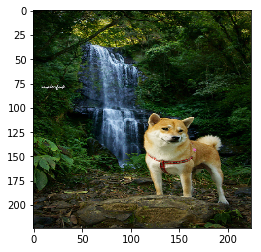

In [82]:
test_p = '/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_35.jpg'
y = cv2.imread(test_p)
y = cv2.resize(y, (224,224))
plt.imshow(cv2.cvtColor(y, cv2.COLOR_BGR2RGB))

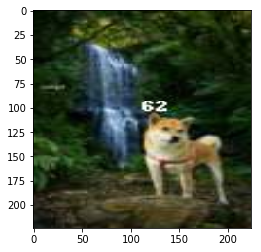

In [83]:
test_p = '/home/jupyter/.fastai/data/oxford-iiit-pet/crappy/shiba_inu_35.jpg'
x = cv2.imread(test_p)
x = cv2.resize(x, (224,224))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))

In [84]:
x = normalization(x)
x = x.reshape((1,) + (224,224,3))
yhat = resUnet_normal.predict(x)
print(yhat.shape)
print(np.max(yhat), np.min(yhat))

(1, 224, 224, 3)
0.9033401 -0.97961426


In [85]:
pred_img = denormalization(yhat[0])
pred_img = np.clip(pred_img, 0, 255)
print(np.max(pred_img), np.min(pred_img))

242.67587 2.5991821


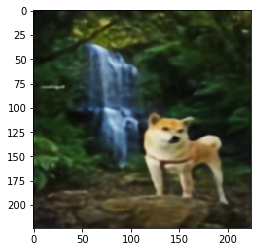

In [86]:
show_im = pred_img.astype('uint8')
plt.imshow(cv2.cvtColor(show_im, cv2.COLOR_BGR2RGB))

In [87]:
# def normalization(img, rgb_mean=DIV2K_RGB_MEAN):
#     return (img - rgb_mean) / 127.5

test_p = '/home/jupyter/.fastai/data/oxford-iiit-pet/images/shiba_inu_35.jpg'
a = cv2.imread(test_p)
a = cv2.resize(a, (224,224))
print(a[100,100,:])

[112  82  58]


In [88]:
b = a - DIV2K_RGB_MEAN

print(b[100,100,:])

[ -2.444  -29.4605 -45.02  ]


In [90]:
b = b / 127
print(b[100,100,:])

[-0.01924409 -0.23197244 -0.35448819]
